In [2]:
#import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

We begin our project by using a dataset containing the evaluations of movies of each user, we download the data from the GoupLens site: https://grouplens.org/datasets/movielens/. 

In [3]:
data = {}
PATH = 'movielens/'

#get titles.
for line in open(PATH+'u.item', encoding='ISO-8859-1'):
    ind, title = line.split('|')[:2]
    data[ind] = title

#get scores
scores = {}
for line in open(PATH+'/u.data'):
    user, ind, score, ts = line.split('\t')

    #scores use the username as key and a dictionary as its value.
    scores.setdefault(user, {})
    #Each dict of scores uses the title as key and the score as its value.
    scores[user][data[ind]] = float(score)

In [4]:
print('information about data(dict of titles)')
print('%d movies in movielens dataset'%len(data))
id_movies = list(data.keys())
print('the keys of data:', ' '.join(id_movies[:10]), '...')
print('the first record of data: {}'.format(data[id_movies[0]]))

print('=================================')
print('information about score(dict of scores)')
print('%d users in movielens dataset'%len(scores))
id_users = list(scores.keys())
print('the keys of scores:', ' '.join(id_users[:5]), '...')
print('the first record of data(just show the first 5 items): \n{}'.format(
    list(scores[id_users[0]].items())[:5]))

information about data(dict of titles)
1682 movies in movielens dataset
the keys of data: 1 2 3 4 5 6 7 8 9 10 ...
the first record of data: Toy Story (1995)
information about score(dict of scores)
943 users in movielens dataset
the keys of scores: 196 186 22 244 166 ...
the first record of data(just show the first 5 items): 
[('Kolya (1996)', 3.0), ('Mrs. Doubtfire (1993)', 4.0), ("Muriel's Wedding (1994)", 4.0), ('Shall We Dance? (1996)', 3.0), ('Stand by Me (1986)', 5.0)]


**note**

The dict scores containing the evalutions of $943$ users for the $1682$ movies. Each score is supposed to be in range $[0.0, 5.0]$.

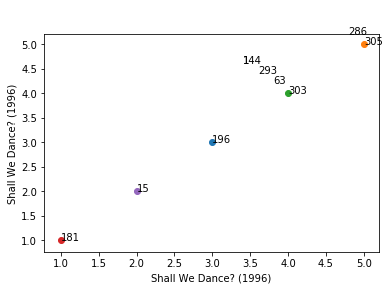

In [5]:
#visualization for the scores fof two movies
#See the scatter_scores() in guess_what_you_like.py
import guess_what_you_like
from guess_what_you_like import scatter_scores
idx_plot = id_users[:200]
scatter_scores(scores, 'Shall We Dance? (1996)', \
               'Shall We Dance? (1996)', idx_plot)
plt.show()

## Diffenrent metrics to evaluate the similarity

We can see from the image that some users give the same scores for both two films(for ex. 144, 293, 63, 303). We can account that they have similar taste if we only consider these two movies. 

In fact, there are many different methods to evaluate sccurately the similarity between users. We choose here Pearson score, Euclidean score and Cosine score and build a function called 'scorer()' in guess_what_you_like.py file.

In [6]:
from guess_what_you_like import scorer
print('scores between user ({0}, {1}) and ({2}, {3})'.format(
    id_users[0], id_users[0], id_users[0], id_users[2]))
for metrics in ['pearson', 'eucildean', 'cosine']:
    print('%s score : %5f, \t %5f'%(metrics, 
                scorer(scores[id_users[0]], scores[id_users[0]], metrics),
                scorer(scores[id_users[0]], scores[id_users[2]], metrics)))

scores between user (196, 196) and (196, 22)
pearson score : 1.000000, 	 0.358045
eucildean score : 1.000000, 	 0.169521
cosine score : 1.000000, 	 0.912264


**note**

The euclidean score is between is between $0$ and $1, 0$ means the two samples are independant.

The pearson score and cosine score are in range $[-1, 1]$, $0$ means independence between them,  $1$ means the two vectors are in the same direction, $-1$ means in the different direction.

Without special instructions, we default the score as cosine score.

## Matching

Now we have the metrics to compare two users' tastes, we could match the similar users. In this part, we'll find the most simliar users with given user. See function 'get_sim_users()' in guess_what_you_like.py file.

In [7]:
from guess_what_you_like import get_sim_user

#Choose randomly 5 users to calculate their similar users.
seed = np.random.RandomState(512)
user_tars = [id_users[_] for _ in  seed.randint(0, len(id_users)-1, size=5)]
sim_users = [get_sim_user(user_tar, scores, n=-1) for user_tar in user_tars]
df_sim_users = pd.DataFrame(sim_users).T
df_sim_users.columns=user_tars
df_sim_users

,444,935,938,778,350
0,"(1.0, 93)","(1.0, 918)","(1.0, 912)","(1.0, 937)","(1.0, 93)"
1,"(1.0, 918)","(1.0, 914)","(1.0, 641)","(1.0, 93)","(1.0, 909)"
2,"(1.0, 914)","(1.0, 912)","(1.0, 571)","(1.0, 926)","(1.0, 906)"
3,"(1.0, 897)","(1.0, 911)","(1.0, 522)","(1.0, 920)","(1.0, 905)"
4,"(1.0, 876)","(1.0, 9)","(1.0, 51)","(1.0, 915)","(1.0, 88)"
...,...,...,...,...,...
937,"(0, 289)","(0, 31)","(0.7753298418327284, 471)","(0, 134)","(0, 439)"
938,"(0, 208)","(0, 302)","(0.6016568375961868, 681)","(0, 133)","(0, 36)"
939,"(0, 172)","(0, 208)","(0, 855)","(0, 131)","(0, 349)"
940,"(0, 167)","(0, 172)","(0, 565)","(0, 112)","(0, 341)"


**note**

This function returns a ordered list of similar users of given user. Then for each user, we can calculate the list of his preference. 

## Recommendations

Now we can recommend some items for each user. The idea here is to get all the similar scores between target user and other users. Then we sort this score and endow the user with a higher similar score a higher weight. Then we calculate the weighted sum of each movie and recommend the movie with highest score to target user. See function recommend() in guess_what_you_like.py file.

In [8]:
from guess_what_you_like import recommend
rcms = [recommend(user_tar, scores, n=-1, train_all=True) for user_tar in user_tars]
df_rcms = pd.DataFrame(rcms, index=user_tars).T
df_rcms.iloc[:5]#each columns is the recommendation list for a user with ID=column name

,444,935,938,778,350
0,"(5.0, Star Kid (1997))","(5.000000000000001, Marlene Dietrich: Shadow a...","(5.000000000000001, Saint of Fort Washington, ...","(5.000000000000001, Prefontaine (1997))","(5.000000000000001, Prefontaine (1997))"
1,"(5.0, Someone Else's America (1995))","(5.0, They Made Me a Criminal (1939))","(5.0, They Made Me a Criminal (1939))","(5.000000000000001, Great Day in Harlem, A (19...","(5.0, They Made Me a Criminal (1939))"
2,"(5.0, Santa with Muscles (1996))","(5.0, Star Kid (1997))","(5.0, Star Kid (1997))","(5.0, They Made Me a Criminal (1939))","(5.0, Star Kid (1997))"
3,"(5.0, Prefontaine (1997))","(5.0, Someone Else's America (1995))","(5.0, Someone Else's America (1995))","(5.0, Star Kid (1997))","(5.0, Someone Else's America (1995))"
4,"(5.0, Marlene Dietrich: Shadow and Light (1996) )","(5.0, Santa with Muscles (1996))","(5.0, Santa with Muscles (1996))","(5.0, Someone Else's America (1995))","(5.0, Santa with Muscles (1996))"


In [9]:
#We can get the movies as a list without the calculated scores.
movies_rcm_0 = [s[1] for s in rcms[0]]
movies_rcm_0[:3]

['Star Kid (1997)',
 "Someone Else's America (1995)",
 'Santa with Muscles (1996)']

As you noticed, we add a parameter called train_all in our function. If train_all==True, then we train on all the movies. Otherwise we only train on the movies that user_tar hasn't scored before. 

We have trained all in the above cell, now let's compare the score with the true score.

In [10]:
for i, user_tar in enumerate(user_tars[1:]):
    score_subs = []
    for movie_tar, score_tar in scores[user_tar].items():
        score_rcm = [score for (score, movie) in rcms[i] if movie==movie_tar]
        if score_rcm:
            score_subs.append(np.abs(score_rcm[0] - score_tar))
    
    print('Error for user %s : %5f'%(user_tar, sum(score_subs)/len(score_subs)))

Error for user 935 : 0.838541
Error for user 938 : 0.941401
Error for user 778 : 1.018508
Error for user 350 : 0.617122


In practice, when we have a large dataset, we generally set train_all = False.

In [11]:
rcms = [recommend(user_tar, scores, n=-1, train_all=False) for user_tar in user_tars]
df_rcms = pd.DataFrame(rcms, index=user_tars).T
df_rcms.iloc[:5]#each columns is the recommendation list for a user with ID=column name

,444,935,938,778,350
0,"(5.0, Star Kid (1997))","(5.000000000000001, Marlene Dietrich: Shadow a...","(5.000000000000001, Saint of Fort Washington, ...","(5.000000000000001, Prefontaine (1997))","(5.000000000000001, Prefontaine (1997))"
1,"(5.0, Someone Else's America (1995))","(5.0, They Made Me a Criminal (1939))","(5.0, They Made Me a Criminal (1939))","(5.000000000000001, Great Day in Harlem, A (19...","(5.0, They Made Me a Criminal (1939))"
2,"(5.0, Santa with Muscles (1996))","(5.0, Star Kid (1997))","(5.0, Star Kid (1997))","(5.0, They Made Me a Criminal (1939))","(5.0, Star Kid (1997))"
3,"(5.0, Prefontaine (1997))","(5.0, Someone Else's America (1995))","(5.0, Someone Else's America (1995))","(5.0, Star Kid (1997))","(5.0, Someone Else's America (1995))"
4,"(5.0, Marlene Dietrich: Shadow and Light (1996) )","(5.0, Santa with Muscles (1996))","(5.0, Santa with Muscles (1996))","(5.0, Someone Else's America (1995))","(5.0, Santa with Muscles (1996))"


**note**

In this recommendation system, the more similar user A is with user B, the larger A will influence B(the weight of A is larger among all the users except B). 

We use the norm_score which is the sum of similarity scores between A and all the other users as the denomitor to normalize the weights. 

## Feedback

Now we want to ameliorate the system through the feedback of the users, i.e. each time we recommends the user a movie, he can choose either click it or not. We'll learn from each click of the users, and then improve the sort strategy to reflect better his/her preference for a while.

To accomplish it, we'll build a neural network. The idea is that we firstly generate $k$ recommendations for target user, then the user will select one movie(movie_selected) from the list and see it. Then he(she) scores for this movie or not, and we add this movie and its score(if any) to database and generate a new recommendation order for him.

The input layer will be the target user, and the output layer will be our recommendations for him/her, and the output layer contains the movies recommended for target users. The idea is selecting the movies with the highest scores to recommend for target user.

See class back_prop()

### Create tables and add items

We build here a database to save the existing users so that we don't need to calculate the similarity scores each time.

We create $5$ tables: 'users(user)' to save the user names, 'movies(movie)' to save the movie names, 'scores(user, movie, score)' to save the scores that each user has evaluated for each movie before, 'sim_scores(user, user_other, sim_score)' to save the similiarity between each pair of users and 'weights(user, user_other, weight)' to save the weights between user and user_other.

In [36]:
from guess_what_you_like import back_prop

#Create a neural network class named rcm_nn.
rcm_nn = back_prop('rcm_net.db')
#Create the tables to save the data. 
#rcm_nn.create_tables() #Uncomment here the first time you creat the table

#Use the first 100 items to train our net.
scores_train = dict(list(scores.items())[:100])
#add the users/movies/scores into the tabels
#rcm_nn.add_items(scores_train)#Uncomment here the first time you creat the table

In [17]:
#By running self.add_items, we've added the users, movies and scores to database.
#Confirm that we have saved our data into the db. 
user_ex, user_ex_1 = list(scores_train.keys())[:2]
movie_ex = list(scores_train[user_ex].keys())[0]
print('length of trained users in library: ', rcm_nn.conn.execute('select count(*) from users').fetchone()[0])
print('length of trained movies in library: ', rcm_nn.conn.execute('select count(*) from movies').fetchone()[0])
print('user %s has scored movie %s: '%(user_ex, movie_ex), \
      rcm_nn.conn.execute('select * from scores where user=? and movie=?', (user_ex, movie_ex)).fetchone()[0])

length of trained users in library:  100
length of trained movies in library:  1448
user 196 has scored movie Kolya (1996):  196


**note**: we haven't added the sim_scores since it takes time to calculate the similarity scores between all the pairs of users since it takes a lot of time.

We'll calculate the sim_score only for the target user later, and each time we calculate the sim_scores, we'll upload it into the database so that we could query the value directly next time.

### Get recommendations

**note** Here we use the same idea as above to reconstruct a recommendation in combination SQL sentences.

In [21]:
rcms = rcm_nn.get_rcms(user_ex)
rcms

99it [00:06, 16.19it/s]
100%|██████████| 99/99 [02:50<00:00,  1.72s/it]


[(3.689454574729102, 'Star Wars (1977)'),
 (3.379201743717848, 'Fargo (1996)'),
 (3.3333167553366536, 'Raiders of the Lost Ark (1981)')]

In [60]:
#Or we could return only the recommendations by setting the parameter show_scores as False.
movies_rcms = rcm_nn.get_rcms(user_ex, 3, show_scores=False)
movies_rcms

['Star Wars (1977)', 'Fargo (1996)', 'Raiders of the Lost Ark (1981)']

In [62]:
#Try another user
movies_rcms_1 = rcm_nn.get_rcms(user_ex_1, 3, show_scores=False)
movies_rcms_1

['Star Wars (1977)', 'Raiders of the Lost Ark (1981)', 'Toy Story (1995)']

**note** During the process of recommendation, we have calculated and saved the sim_scores in our database. Let's check it!

In [63]:
list(rcm_nn.conn.execute('select count(*) from sim_scores'))[0]
#We have calculated the sim_scores between user_ex and all the other 99 users, count=99
#Then we added the user_ex_1 and calculated its sim_score with other 98 users, count+=98

(197,)

**note**
For a new user, we'll generate the recommendations randomly and save it into database.

In [27]:
user_new = '2000'
movies_rcms_new = rcm_nn.get_rcms(user_new, 3, show_scores=False)
print(movies_rcms_new)

['Citizen Kane (1941)', 'Third Man, The (1949)', 'Leopard Son, The (1996)']


### Back propagation

In [20]:
rcm_nn.setup(user_ex)#set up the nodes and weights.
rcm_nn.feed_forward(user_ex)

99it [00:05, 18.37it/s]
100%|██████████| 99/99 [02:52<00:00,  1.74s/it]


[0.9987522159434636,
 0.9976805303410549,
 0.9974578832959576,
 0.9967722166353429,
 0.9964589535867099,
 0.9959675233417048,
 0.9950027877094826,
 0.9937067903368972,
 0.9935216150793461,
 0.9924383127545919]

**note** Here we choose tanh() function as our activation function. 

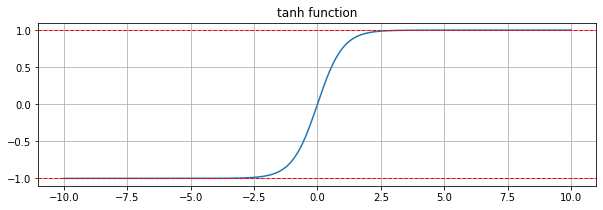

In [80]:
plt.figure(figsize=(10, 3))
plt.title('tanh function')
x = np.linspace(-10, 10, 1000)
y = np.tanh(x)
plt.plot(x, y)
plt.grid()
plt.axhline(1, linestyle='--', lw=1, color='r')
plt.axhline(-1, lw=1, linestyle='--', color='r')
plt.show()

### Train the feedback

Then we build a function back_prop() to calculate the error of output layer and adjust the weights. We need a function d_tanh() in this part to represent the influence degree. We can see from the above picture 'tanh function' that the activation function is quite steep near $0$, and very smooth when the absolute value of x is large enough.
So in the steep points, we could obtain the required change of $tanh(x)$ by changing just a bit the $x$, while in the smooth points, the situation is opposite. We hence adjust the weight by multiplying the derivative of activation function: $d\_tanh(x)\times err(x)$.

Here we build a function update_db() to update the database or insert the weights into the database.

And we run the function train() to train our neural network through the feedback of users.
Assuming here user_ex has selected the movie ''Fargo (1996)'' from the recommendation list 'movies_rcm'. And we default the learning rate as $0.25$.

In [54]:
rcm_nn.train(user_ex, movies_rcms, movies_rcms[1])

After training the feedback, we've updated the weights as following:

In [53]:
print('The original weights')
print(rcms)
print('='*60)

print('The updated weights')
print(rcm_nn.conn.execute('select weight, movie from weights where user=?', (user_ex, )).fetchall())

The original weight
[(3.689454574729102, 'Star Wars (1977)'), (3.379201743717848, 'Fargo (1996)'), (3.3333167553366536, 'Raiders of the Lost Ark (1981)')]
The updated weight
[(3.686959801141529, 'Star Wars (1977)'), (3.3792124909741093, 'Fargo (1996)'), (3.32823588889914, 'Raiders of the Lost Ark (1981)')]


**note** since the user has selected the movie Fargo, the neural has increased the weight of it and reduce the weights of others to some degree.

But we've noticed the adjustment is quite small, that's because we used the scores as weights, which are larger than $1$. We can see from the above figure 'tanh function' that the slope is quite small when the absolue value of $x$ is larger than $1$.To fix this, we normalize the weights.

We revise it directly in the py file(line 351)

In [56]:
rcm_nn.train(user_ex, movies_rcms, movies_rcms[1])

In [59]:
print('The original normalized weights')
sum_rcms = sum([_[0] for _ in rcms])
rcms_normed = [(_[0]/sum_rcms, _[1]) for _ in rcms]
print(rcms_normed)
print('='*60)

print('The updated weights')
print(rcm_nn.conn.execute('select weight, movie from weights where user=?', (user_ex, )).fetchall())

The original normalized weights
[(0.35468795665581393, 'Star Wars (1977)'), (0.3248616122872447, 'Fargo (1996)'), (0.32045043105694143, 'Raiders of the Lost Ark (1981)')]
The updated weights
[(0.20418774682400195, 'Star Wars (1977)'), (0.6342549991952408, 'Fargo (1996)'), (0.18011573219615512, 'Raiders of the Lost Ark (1981)')]


**note** We could control the changing degree by changing the parameter learning_rate.

### Apply to the whole data

Now, let's proceed our codes into the whole dataset, which may takes a few minutes to add items and caculate the sim_scores to get recommendations.

In [47]:
rcm_nn_whole = back_prop('rcm_net_whole.db')
rcm_nn_whole.create_tables()
rcm_nn.add_items(scores)
print('length of trained users in library: ', rcm_nn.conn.execute('select count(*) from users').fetchone()[0])
print('length of trained movies in library: ', rcm_nn.conn.execute('select count(*) from movies').fetchone()[0])
print('user %s has scored movie %s: '%(user_ex, movie_ex), \
      rcm_nn.conn.execute('select * from scores where user=? and movie=?', (user_ex, movie_ex)).fetchone()[0])

length of trained users in library:  943
length of trained movies in library:  1664
user 196 has scored movie Kolya (1996):  196


In [60]:
rcms_ex = rcm_nn_whole.get_rcms(user_ex, 3)#takes about 4 hours.

942it [13:07,  1.20it/s] 
100%|██████████| 942/942 [3:55:41<00:00, 15.01s/it]  


In [61]:
rcms_ex

[(3.101960343781825, 'Star Wars (1977)'),
 (2.7146438574151563, 'Fargo (1996)'),
 (2.5068804270658136, 'Return of the Jedi (1983)')]

## To be improved

There are still a lot of things that could be added into our model:

- We could consider the situation where the user has no interest in any movie in our recommendation list and recreate a new list in this case.
- We could add some hidden layers to improve the performance of our neural network.
- We've tried to apply the back propagration to the whole dataset(943), which may takes about $4$ hours. So we should find a way to improve the efficiency. But since it just 